# Enmarcar el problema
### Objetivo
El objetivo de este documento es hacer un proyecto de ML de principio a fin para practicar todos los pasos que hay que seguir en un proyecto profesional.
- Enmarcar el problema
- Obtener los datos
- Explorar los datos
- Preprocesamiento
- Explorar muchos modelos distintos
- Perfeccionar los mejores modelos
- Presentar una solución lo más precisa posible.

### Breve Descripción
El dataset del Titanic es uno de los conjuntos de datos más utilizados para aprender sobre análisis de datos y machine learning. Se refiere a los pasajeros a bordo del **RMS Titanic**, el famoso transatlántico que se hundió en su viaje inaugural en 1912.

### Tipo de sistema de ML
Aprendizaje supervisado, por lotes, basado en modelos e instancias.

### ¿Cómo debería medirse el rendimiento?
El problema es de clasificación binaria, ya que hay que predecir si el pasajero sobrevive o no. Para medir el rendimiento de los modelos puede utilizarse la métrica "Accuracy". También será interesante ver el **F1 score**, que pondera de igual forma la precisión y la sensibilidad.

Además, dado que puede haber cierto desbalance entre las clases, se utilizará la **curva de precisión-sensibilidad** para elegir el mejor umbral de decisión. Finalmente, también se calculará la métrica **ROC AUC** como una medida global de rendimiento del modelo.


# Descargar el conjunto de datos

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import tarfile
import urllib.request
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import randint, uniform, loguniform

In [ ]:
def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://homl.info/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
          titanic_tarball.extractall(path="datasets")

In [ ]:
titanic = load_titanic_data()

In [ ]:
train = pd.read_csv("datasets/titanic/train.csv")
test = pd.read_csv("datasets/titanic/test.csv")

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.shape

(891, 12)

In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
test.shape

(418, 11)

In [ ]:
X_test = test

# Dividir los datos de entrenamiento

# Explorar los datos

### Descripción del Dataset
El dataset contiene información sobre **891 pasajeros**, con varias características que se pueden utilizar para predecir si un pasajero sobrevivió o no al hundimiento. Las columnas principales son:

- **PassengerId**: Identificador único para cada pasajero.
- **Survived**: Variable objetivo (0 = No sobrevivió, 1 = Sobrevivió).
- **Pclass**: Clase del boleto del pasajero (1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase).
- **Name**: Nombre del pasajero.
- **Sex**: Género del pasajero (male, female).
- **Age**: Edad del pasajero en años (algunos valores nulos).
- **SibSp**: Número de hermanos o cónyuges a bordo del Titanic.
- **Parch**: Número de padres o hijos a bordo del Titanic.
- **Ticket**: Número del boleto del pasajero.
- **Fare**: Precio pagado por el boleto, en libras esterlinas (£).
- **Cabin**: Número de la cabina del pasajero (muchos valores faltantes).
- **Embarked**: Puerto de embarque (C = Cherburgo, Q = Queenstown, S = Southampton).

### Estudio de los atributos y sus características
- **PassengerId**: Independiente, atributo, numérico, discreto, Acotado (Entre 1 y el total de pasajeros).
- **Survived**: Dependiente, atributo, numérico, binario, Acotado (0 o 1).
- **Pclass**: Independiente, atributo, numérico, discreto, Acotado (1, 2 o 3).
- **Name**: Independiente, atributo, categórico, nominal
- **Sex**: Independiente, atributo, categórico, nominal
- **Age**: Independiente, atributo, numérico, continuo, Acotado (Entre 0 y 120 teóricamente).
- **SibSp**: Independiente, atributo, numérico, discreto, Acotado (Entre 0 y 8)
- **Parch**: Independiente, atributo, numérico, discreto, Acotado (Entre 0 y 6)
- **Ticket**: Independiente, atributo, categórico, nominal
- **Fare**: Dependiente de Pclass, atributo, numérico, continuo, Acotado (Entre 0 y un máximo que era la tarifa más cara)
- **Cabin**: Dependiente de Pclass, atributo, categórico, nominal
- **Embarked**: Independiente, atributo, categórico, nominal

### Potenciales desventajas

- Parece que hay muchos valores faltantes en el valor de Cabin y Age.

- Desbalance en la variable objetivo Survived. Hay casi el doble de muertos que de supervivientes. Si el modelo se entrena con un conjunto desbalanceado, puede tener un sesgo hacia la clase mayoritaria.

- Las variables categóricas, como Sex, Embarked, y Ticket, deben ser adecuadamente codificadas.

- Atributos como PassengerId y Ticket pueden no ser informativos para el modelo y pueden introducir ruido si se incluyen sin una transformación adecuada.

- La columna Fare puede contener valores atípicos que pueden distorsionar el análisis y la modelización. Por ejemplo, algunos pasajeros pueden haber pagado tarifas extremadamente altas, lo que podría influir en el modelo.

### Conjeturas sobre los datos
- Es probable que los varones mayores de edad sean el grupo con menos supervivéncia de todos, dado el contexto histórico en el que se basa.

- Puede ser que los pasajeros en primera clase tengan más probabilidades de salvarse, ya que estos suelen hospedarse en la parte más alta del barco cerca de los botes salvavidas.

- Probablemente, la edad sea un factor muy determinante para predecir si una persona sobrevive o no.

- Podrían obtenerse títulos de los nombres que podrían ser relevantes para saber el estado civil y la clase social del pasajero y sus probabilidades de sobrevivir.

- Podría ser útil analizar cómo la presencia de familiares (a través de las columnas SibSp y Parch) afecta la supervivencia. Es posible que las personas que viajaban con familiares tuvieran diferentes probabilidades de supervivencia, ya que los pasajeros podrían intentar ayudar a sus seres queridos.

- La tarifa pagada (Fare) podría ser un buen indicador del estatus social y podría correlacionarse con la supervivencia.

In [ ]:
X = train.drop('Survived', axis=1)
y = train['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(712, 11)

In [ ]:
X_train.head(15)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
733,734,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
382,383,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
704,705,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
813,814,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S
118,119,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
536,537,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S
361,362,2,"del Carlo, Mr. Sebastiano",male,29.0,1,0,SC/PARIS 2167,27.7208,NaN,C
29,30,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S
55,56,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S


In [ ]:
X_train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,572.000000,712.000000,712.000000,712.000000
mean,448.234551,2.330056,29.498835,0.553371,0.379213,32.586276
std,256.731423,0.824584,14.500082,1.176404,0.791669,51.969529
min,1.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,224.750000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,453.500000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,673.500000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
X_train[X_train['Fare'] > 500]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
737,738,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
679,680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
258,259,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Name         712 non-null    object 
 3   Sex          712 non-null    object 
 4   Age          572 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        159 non-null    object 
 10  Embarked     710 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


In [ ]:
y_train.value_counts()

,count
Survived,
0,444
1,268


In [ ]:
porcentaje_unos = (y_train.sum() / len(y_train)) * 100
print(f"El porcentaje de supervivientes es: {porcentaje_unos:.2f}%")


El porcentaje de supervivientes es: 37.64%


In [ ]:
X_train['Sex'].value_counts()

,count
Sex,
male,467
female,245


In [ ]:
X_train.isnull().sum().sort_values(ascending=False)

,0
Cabin,553
Age,140
Embarked,2
PassengerId,0
Pclass,0
Name,0
Sex,0
SibSp,0
Parch,0
Ticket,0


In [ ]:
(X_train.isnull().sum() / len(X_train) * 100 ).sort_values(ascending=False)

,0
Cabin,77.668539
Age,19.662921
Embarked,0.280899
PassengerId,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
SibSp,0.000000
Parch,0.000000
Ticket,0.000000


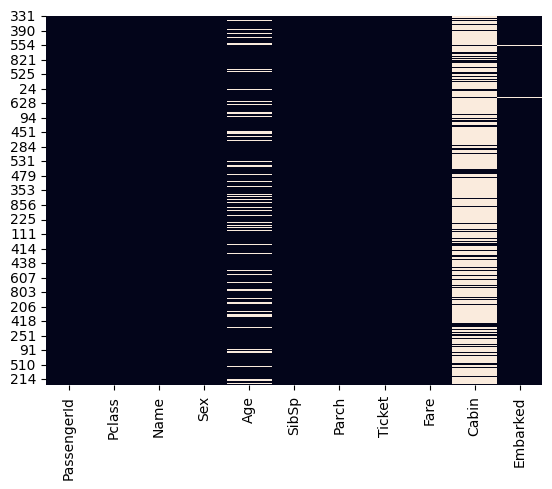

In [ ]:
# Mostrar los valores nulos
sns.heatmap(X_train.isnull(), cbar=False)
plt.show()

# Visualizar los datos

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

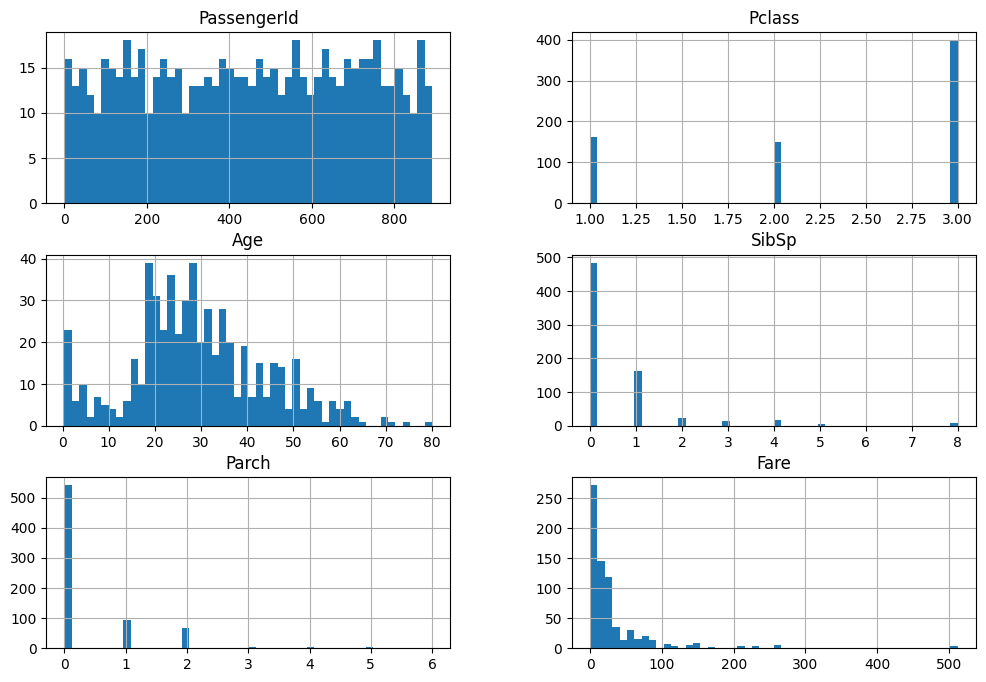

In [ ]:
X_train.hist(bins=50, figsize=(12,8))

In [ ]:
X_train['Embarked'].value_counts()

,count
Embarked,
S,525
C,125
Q,60


In [ ]:
cabin_counts = X_train['Cabin'].value_counts()
sorted_cabin_counts = cabin_counts.sort_index()
print(sorted_cabin_counts)

Cabin
A10    1
A14    1
A16    1
A19    1
A23    1
      ..
F33    2
F38    1
F4     2
G6     3
T      1
Name: count, Length: 117, dtype: int64


In [ ]:
X_train['Ticket'].value_counts()

,count
Ticket,
CA. 2343,7
347082,6
1601,6
CA 2144,6
3101295,5
...,...
330923,1
244252,1
349254,1


In [ ]:
numeric_values = train.select_dtypes(include=['number'])
corr_matrix = numeric_values.corr()
corr_matrix["Survived"].sort_values(ascending=False)

,Survived
Survived,1.000000
Fare,0.257307
Parch,0.081629
PassengerId,-0.005007
SibSp,-0.035322
Age,-0.077221
Pclass,-0.338481


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` 

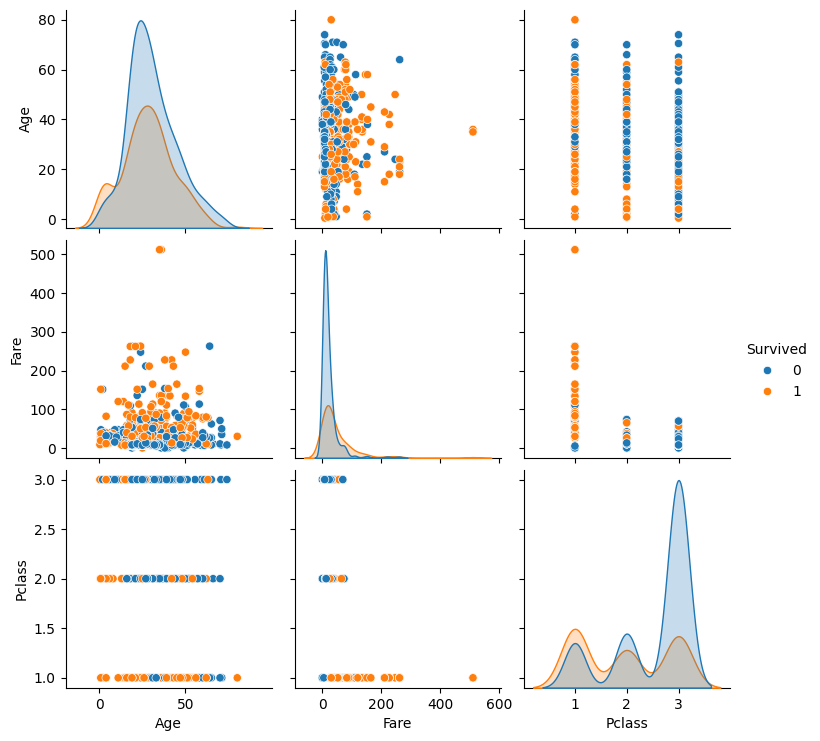

In [ ]:
features = ['Age', 'Fare', 'Pclass']
sns.pairplot(train, hue='Survived', vars=features)
plt.show()

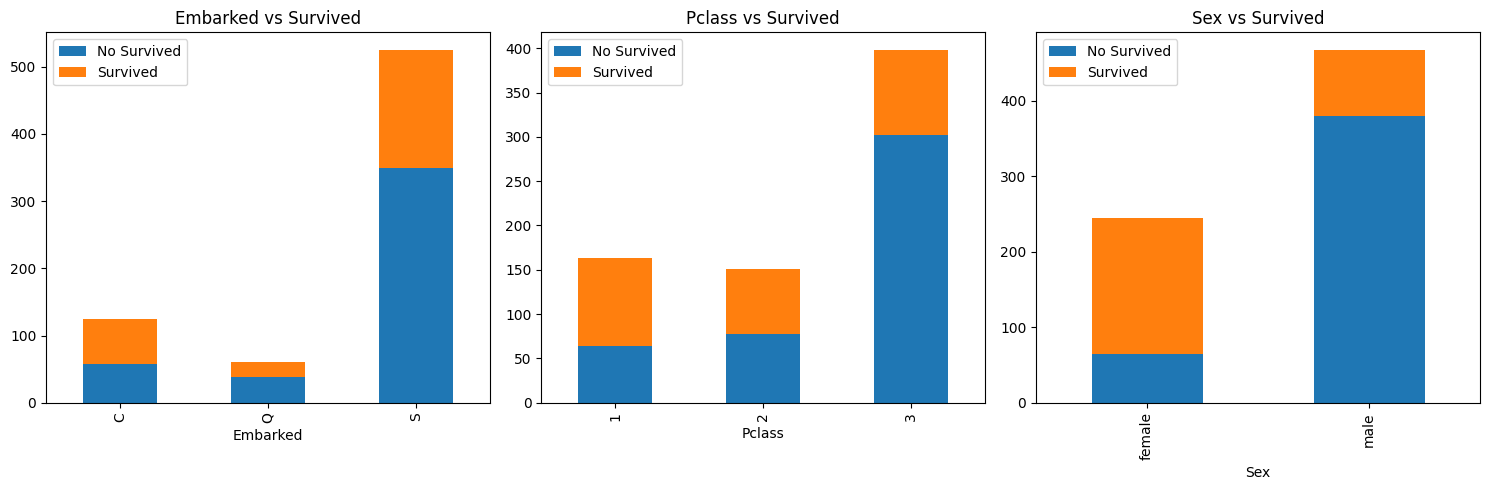

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico para 'Embarked'
embarked_survived = pd.crosstab(X_train['Embarked'], y_train)
embarked_survived.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Embarked vs Survived')
axes[0].legend(['No Survived', 'Survived'])

# Gráfico para 'Pclass'
pclass_survived = pd.crosstab(X_train['Pclass'], y_train)
pclass_survived.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Pclass vs Survived')
axes[1].legend(['No Survived', 'Survived'])

# Gráfico para 'Sex'
sex_survived = pd.crosstab(X_train['Sex'], y_train)
sex_survived.plot(kind='bar', stacked=True, ax=axes[2])
axes[2].set_title('Sex vs Survived')
axes[2].legend(['No Survived', 'Survived'])

plt.tight_layout()
plt.show()


In [ ]:
survival_by_pclass = train.groupby('Pclass')['Survived'].mean()
print(survival_by_pclass)


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


# Preparar los datos

In [ ]:
class WomanOrBoyClassifer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = pd.DataFrame(X, columns=['Sex', 'Title'])
        X_copy['WomanOrBoy'] = X_copy.apply(lambda row: 'WomanOrBoy' if row['Sex'] == 'female' or row['Title'] == 'Master' else 'Man', axis=1)
        return X_copy[['WomanOrBoy']].values

    def get_feature_names_out(self, input_features=None):
        return ['WomanOrBoy']

In [ ]:
class NameImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['Name'] = X_copy.apply(lambda row: self._impute_name(row), axis=1)
        return X_copy[['Name']].values

    def _impute_name(self, row):
        if pd.isnull(row['Name']):
            if row['Sex'] == 'male':
                return "Unknown, Mr."
            else:
                return "Unknown, Miss."
        return row['Name']

    def get_feature_names_out(self, input_features=None):
        return ['Name']

In [ ]:
class TitleExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_name = X[:, 0]
        titles = pd.Series(X_name).str.extract(r',\s*([^\.]*)\.', expand=False)
        return titles.values.reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return ['Title']

In [ ]:
class SurnameExtractor(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X_copy = pd.DataFrame(X, columns=['Name'])
    X_copy['Surname'] = X_copy['Name'].str.split(',').str[0].fillna('')
    return X_copy[['Surname']].values

  def get_feature_names_out(self, input_features=None):
    return ['Surname']

In [ ]:
class AgeImputerByClass(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.iqr_dict_ = {}
        for pclass, group in X.groupby('Pclass'):
            q1 = group['Age'].quantile(0.25)
            q3 = group['Age'].quantile(0.75)
            self.iqr_dict_[pclass] = (q1, q3)

        return self

    def transform(self, X, y=None):
        X_copy = X.copy()

        # Función para imputar la edad aleatoria dentro del rango intercuartílico
        def impute_age(row):
            if pd.isnull(row['Age']):
                q1, q3 = self.iqr_dict_[row['Pclass']]
                return np.random.randint(int(q1), int(q3) + 1)
            else:
                return row['Age']

        X_copy['Age'] = X_copy.apply(impute_age, axis=1)
        return X_copy[['Age']].values

    def get_feature_names_out(self, input_features=None):
        return ['Age']

In [ ]:
class CabinImputerFromSurname(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X_copy = X.copy()
        self.surname_cabin_mode_ = X_copy.groupby('Surname')['Cabin'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
        return self

    def _impute_cabin(self, row):
        if pd.isna(row['Cabin']):
            return self.surname_cabin_mode_.get(row['Surname'], None)
        return row['Cabin']

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['Cabin'] = X_copy.apply(lambda row: self._impute_cabin(row), axis=1)
        return X_copy[['Cabin', 'Ticket']]

    def get_feature_names_out(self, input_features=None):
      return ['Cabin', 'Ticket']

In [ ]:
class CabinImputerFromTicket(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.ticket_cabin_map = (
            X[['Ticket', 'Cabin']]
            .dropna()
            .groupby('Ticket')['Cabin']
            .agg(lambda x: x.mode()[0])
            .to_dict()
        )
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()

        X_copy['Cabin'] = X_copy.apply(
            lambda row: self.ticket_cabin_map.get(row['Ticket'], 'Unknown')
            if pd.isna(row['Cabin']) else row['Cabin'],
            axis=1
        )
        return X_copy[['Cabin']]

    def get_feature_names_out(self, input_features=None):
        return ['Cabin']

In [ ]:
class CabinTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X_copy = X.copy()
    X_copy['CabinRank'] = 'Unknown'
    X_copy.loc[X_copy['Cabin'].str.startswith(('A', 'B', 'C')), 'CabinRank'] = 'A_B_C'
    X_copy.loc[X_copy['Cabin'].str.startswith(('D', 'E')), 'CabinRank'] = 'D_E'
    X_copy.loc[X_copy['Cabin'].str.startswith(('F', 'G')), 'CabinRank'] = 'F_G'

    return X_copy[['CabinRank']]

  def get_feature_names_out(self, input_features=None):
        return ['CabinRank']

In [ ]:
class FamilySizeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_df = pd.DataFrame(X, columns=['SibSp', 'Parch'])
        X_df['FamilySize'] = X_df['SibSp'] + X_df['Parch']
        return X_df[['FamilySize']].values

    def get_feature_names_out(self, input_features=None):
        return ['FamilySize']

In [ ]:
class FamilySizeClassifier(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = pd.DataFrame(X, columns=['FamilySize'])
        X_copy['FamilySize'] = X_copy['FamilySize'].apply(family_size_to_cat)
        return X_copy[['FamilySize']].values

    def get_feature_names_out(self, input_features=None):
        return ['FamilySize']

In [ ]:
def family_size_to_cat(number):
    if number==0:
        return "Alone"
    elif number>0 and number <5:
        return "Small"
    else:
        return "Large"

In [ ]:
class TitleClassifier(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        married_titles = ['Mrs', 'Mme', 'the Countess', 'Lady']
        marital_status = []

        X['Married_Woman'] = X['Title'].apply(lambda title: 'Married' if title in married_titles else 'Single')
        married_women_surnames = set(X.loc[X['Married_Woman'] == 'Married', 'Surname'])

        # Clasificar a hombres como casados si comparten el apellido con una mujer casada
        for i, row in X.iterrows():
            if row['Title'] == 'Mr' and row['Surname'] in married_women_surnames:
                marital_status.append('Married')
            else:
                marital_status.append(row['Married_Woman'])

        return np.array(marital_status).reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return ['Marital_Status']

In [ ]:
class CustomFunctionTransformer(FunctionTransformer):
  def get_feature_names_out(self, input_features=None):
      return input_features

In [ ]:
def to_dataframe_1(X):
    return pd.DataFrame(X, columns=first_processing.get_feature_names_out())

def to_dataframe_2(X):
    df = pd.DataFrame(X, columns=second_processing.get_feature_names_out(), dtype=float)
    df.index = df['PassengerId'] - 1
    df.drop('PassengerId', axis=1, inplace=True)
    return df

def remove_columns(X):
    X.drop(['CabinRank_A_B_C', 'CabinRank_D_E', 'CabinRank_F_G', 'CabinRank_Unknown'], axis=1, inplace=True)
    return X

In [ ]:
WomanOrBoy_pipeline = make_pipeline(
    WomanOrBoyClassifer(),
    OrdinalEncoder()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    CustomFunctionTransformer(np.log1p),
    MinMaxScaler()
)

sqrt_pipeline = make_pipeline(
    AgeImputerByClass(),
    KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans'),
    MinMaxScaler()
)

scaler_pipeline= make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler()
)

title_pipeline = make_pipeline(
    NameImputer(),
    TitleExtractor(),
)

surname_pipeline = make_pipeline(
    NameImputer(),
    SurnameExtractor(),
)

cabinet_pipeline = make_pipeline(
    CabinImputerFromSurname(),
    CabinImputerFromTicket(),
    CabinTransformer(),
    OneHotEncoder(handle_unknown="ignore")
)

familySize_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FamilySizeTransformer(),
    FamilySizeClassifier(),
    OneHotEncoder()
)

married_pipeline = make_pipeline(
    TitleClassifier(),
    OrdinalEncoder()
)

In [ ]:
# Primer ColumnTransformer para crear las características 'title__Title', 'title__Surname', family__FamilySize
first_processing = ColumnTransformer([
    ("title", title_pipeline, ["Name"]),
    ("surname", surname_pipeline, ["Name"]),
], remainder='passthrough', verbose_feature_names_out=False)

# Segundo ColumnTransformer para procesar el resto de características
second_processing = ColumnTransformer([
    ("id", 'passthrough', ["PassengerId"]),
    ("WomanOrBoy", WomanOrBoy_pipeline, ["Sex", "Title"]),
    ("fare", log_pipeline, ["Fare"]),
    ("age", sqrt_pipeline, ["Age", "Pclass"]),
    ("pclass", scaler_pipeline, ["Pclass"]),
    ("married", married_pipeline, ["Title", "Surname"]),
    ("embarked", cat_pipeline, ["Embarked"]),
    ("cabinet", cabinet_pipeline, ["Surname", "Ticket", "Cabin"]),
    ("family", familySize_pipeline, ["SibSp", "Parch"]),
], verbose_feature_names_out=False)

preprocessing_pipeline = make_pipeline(
    first_processing,
    CustomFunctionTransformer(to_dataframe_1),
    second_processing,
    CustomFunctionTransformer(to_dataframe_2),
)

processing_pipeline = make_pipeline(
    preprocessing_pipeline,
    CustomFunctionTransformer(remove_columns),
)

In [ ]:
processed_df = preprocessing_pipeline.fit_transform(X_train)
processed_df

,WomanOrBoy,Fare,Age,Pclass,Marital_Status,Embarked_C,Embarked_Q,Embarked_S,CabinRank_A_B_C,CabinRank_D_E,CabinRank_F_G,CabinRank_Unknown,FamilySize_Alone,FamilySize_Large,FamilySize_Small
PassengerId,,,,,,,,,,,,,,,
331.0,0.0,0.542291,0.75,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
733.0,0.0,0.422864,0.25,0.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
382.0,0.0,0.350727,0.50,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
704.0,0.0,0.349451,0.25,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
813.0,1.0,0.556696,0.00,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106.0,1.0,0.345712,0.25,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
270.0,0.0,0.555325,0.50,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
860.0,0.0,0.435071,0.75,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# Visualizar las variables activas (feature engineering)

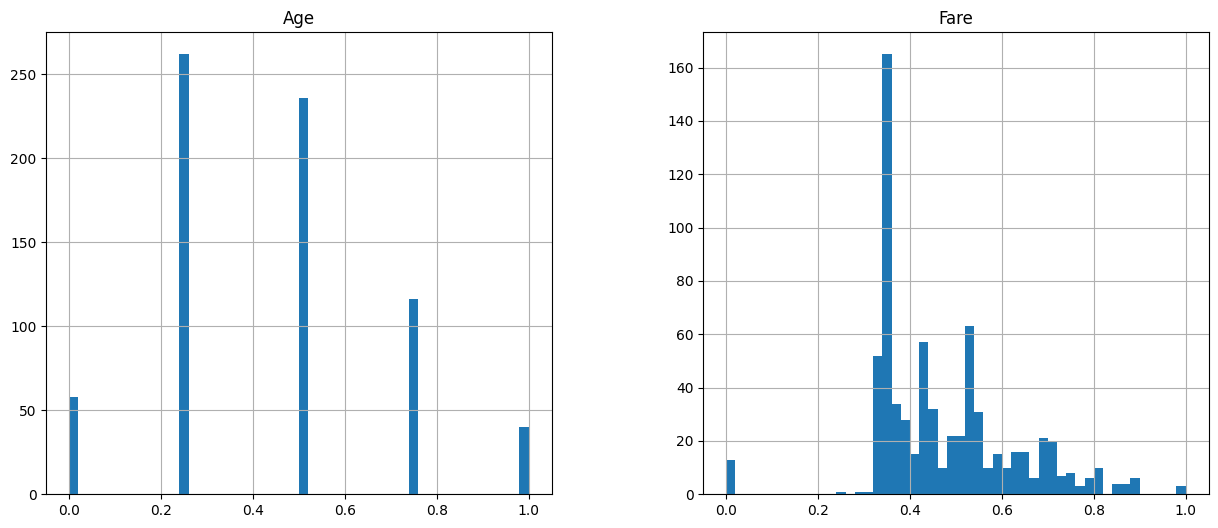

In [ ]:
processed_df[['Age', 'Fare']].hist(bins=50, figsize=(15, 6))
plt.show()

In [ ]:
processed_df['WomanOrBoy'].value_counts()

,count
WomanOrBoy,
0.0,434
1.0,278


In [ ]:
corr_matrix = processed_df.corr()

threshold = 0.7
collinear_pairs = [(col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns
                   if col1 != col2 and abs(corr_matrix[col1][col2]) > threshold]

print("Colinear variables:", collinear_pairs)

Colinear variables: [('Pclass', 'CabinRank_Unknown'), ('Embarked_C', 'Embarked_S'), ('Embarked_S', 'Embarked_C'), ('CabinRank_A_B_C', 'CabinRank_Unknown'), ('CabinRank_Unknown', 'Pclass'), ('CabinRank_Unknown', 'CabinRank_A_B_C'), ('FamilySize_Alone', 'FamilySize_Small'), ('FamilySize_Small', 'FamilySize_Alone')]


(712,)
Index([331, 733, 382, 704, 813, 118, 536, 361,  29,  55,
       ...
       121, 614,  20, 700,  71, 106, 270, 860, 435, 102],
      dtype='int64', length=712)

(712, 15)
Index([331.0, 733.0, 382.0, 704.0, 813.0, 118.0, 536.0, 361.0,  29.0,  55.0,
       ...
       121.0, 614.0,  20.0, 700.0,  71.0, 106.0, 270.0, 860.0, 435.0, 102.0],
      dtype='float64', name='PassengerId', length=712)


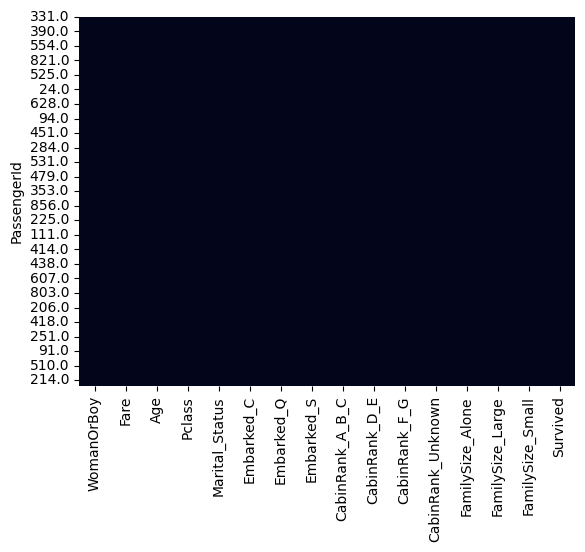

Valores nulos encontrados:  0
Valores no numericos encontrados 0


In [ ]:
processed_df_survived = processed_df.copy()
processed_df_survived['Survived'] = y_train

print(y_train.shape)
print(y_train.index)
print()
print(processed_df.shape)
print(processed_df.index)

# Mostrar los valores nulos
sns.heatmap(processed_df_survived.isnull(), cbar=False)
plt.show()

print("Valores nulos encontrados: ", processed_df_survived.isnull().sum().sum())
print("Valores no numericos encontrados", processed_df_survived.isna().sum().sum())

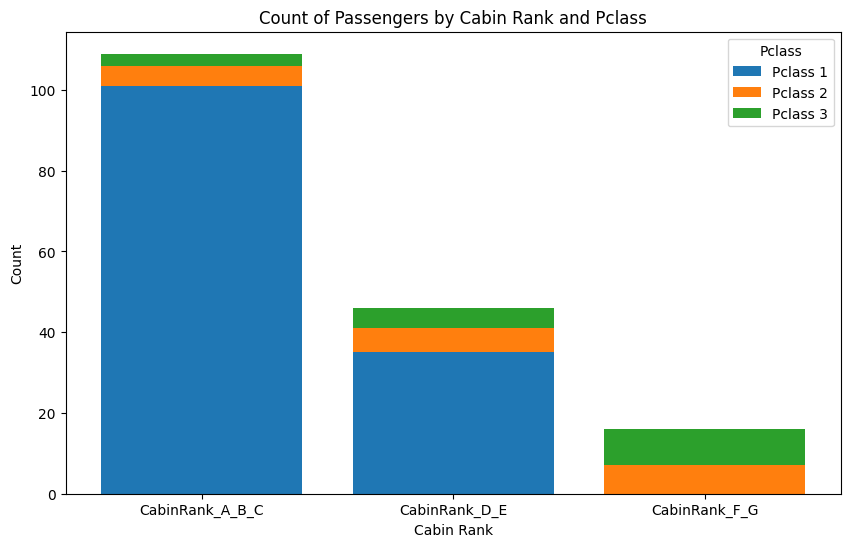

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cabin_rank_columns = ['CabinRank_A_B_C', 'CabinRank_D_E', 'CabinRank_F_G']
pclass_values = [0, 0.5, 1]

fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(cabin_rank_columns))

# Mapeo de Pclass
pclass_mapping = {0: 1, 0.5: 2, 1: 3}

for pclass in pclass_values:
    counts = []
    for cabin_rank_column in cabin_rank_columns:
        count = processed_df_survived[(processed_df_survived['Pclass'] == pclass) &
                                       (processed_df_survived[cabin_rank_column] == 1)][cabin_rank_column].count()
        counts.append(count)
    # Usar el mapeo para renombrar la clase en la leyenda
    ax.bar(cabin_rank_columns, counts, label=f'Pclass {pclass_mapping[pclass]}', bottom=bottom)
    bottom += np.array(counts)

ax.set_xlabel('Cabin Rank')
ax.set_ylabel('Count')
ax.set_title('Count of Passengers by Cabin Rank and Pclass')
ax.legend(title='Pclass')

plt.show()


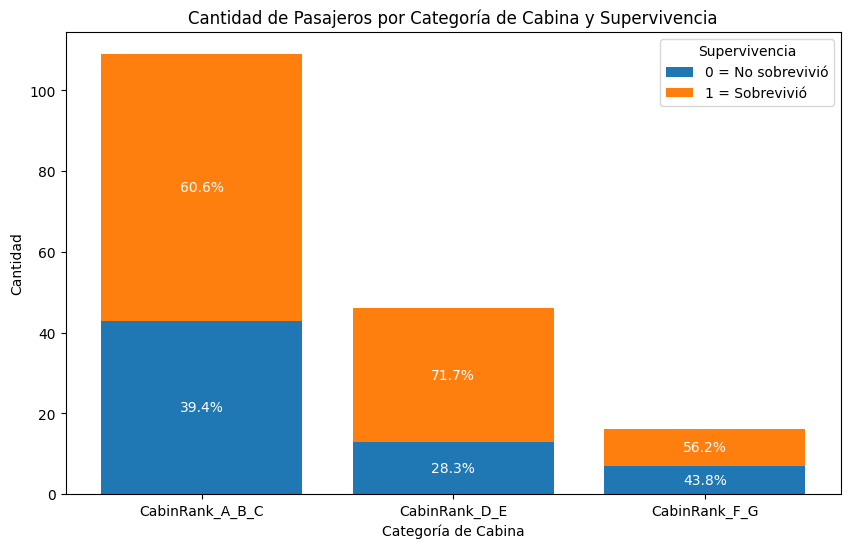

In [ ]:
cabin_rank_columns = ['CabinRank_A_B_C', 'CabinRank_D_E', 'CabinRank_F_G']
survival_values = [0, 1]

fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(cabin_rank_columns))

total_by_cabin = []
for cabin_rank_column in cabin_rank_columns:
    total = processed_df_survived[processed_df_survived[cabin_rank_column] == 1][cabin_rank_column].count()
    total_by_cabin.append(total)

for survival in survival_values:
    counts = []
    for cabin_rank_column in cabin_rank_columns:
        count = processed_df_survived[
            (processed_df_survived['Survived'] == survival) &
            (processed_df_survived[cabin_rank_column] == 1)
        ][cabin_rank_column].count()
        counts.append(count)

    ax.bar(cabin_rank_columns, counts, label=f'{survival} = {"No sobrevivió" if survival == 0 else "Sobrevivió"}', bottom=bottom)
    bottom += np.array(counts)

for i, cabin_rank_column in enumerate(cabin_rank_columns):
    total = total_by_cabin[i]
    count_no_survived = processed_df_survived[
        (processed_df_survived['Survived'] == 0) &
        (processed_df_survived[cabin_rank_column] == 1)
    ][cabin_rank_column].count()
    percentage_no_survived = (count_no_survived / total) * 100 if total != 0 else 0
    ax.text(i, count_no_survived / 2, f'{percentage_no_survived:.1f}%', ha='center', va='center', color='white', fontsize=10)

    count_survived = processed_df_survived[
        (processed_df_survived['Survived'] == 1) &
        (processed_df_survived[cabin_rank_column] == 1)
    ][cabin_rank_column].count()
    percentage_survived = (count_survived / total) * 100 if total != 0 else 0
    ax.text(i, count_no_survived + count_survived / 2, f'{percentage_survived:.1f}%', ha='center', va='center', color='white', fontsize=10)

ax.set_xlabel('Categoría de Cabina')
ax.set_ylabel('Cantidad')
ax.set_title('Cantidad de Pasajeros por Categoría de Cabina y Supervivencia')
ax.legend(title="Supervivencia")

plt.show()


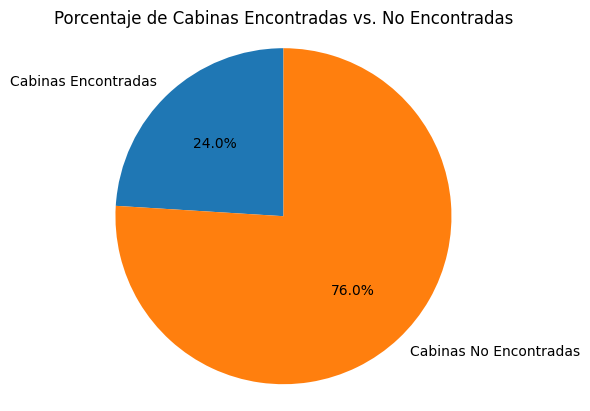

In [ ]:
cabin_rank_counts = processed_df[['CabinRank_A_B_C', 'CabinRank_D_E', 'CabinRank_F_G']].sum().sum()
unknown_cabin_count = processed_df['CabinRank_Unknown'].sum()

labels = ['Cabinas Encontradas', 'Cabinas No Encontradas']
sizes = [cabin_rank_counts, unknown_cabin_count]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')

plt.title('Porcentaje de Cabinas Encontradas vs. No Encontradas')
plt.show()


Después de intentar recuperar todos los datos de cabina que se ha podido siguen faltando demasiados valores. Los datos recuperados pueden no ser representativos o añadir ruido al modelo final que prediga los resultados. Por lo cual, se decide descartar los atributos de Cabina.

In [ ]:
processed_df['Marital_Status'].value_counts()

,count
Marital_Status,
1.0,565
0.0,147


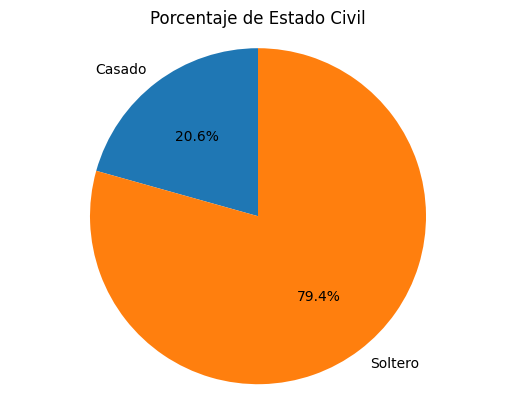

In [ ]:
marital_status_counts = processed_df['Marital_Status'].value_counts()

labels = ['Casado', 'Soltero']
sizes = [marital_status_counts.get(0.0, 0), marital_status_counts.get(1.0, 0)]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')

plt.title('Porcentaje de Estado Civil')
plt.show()


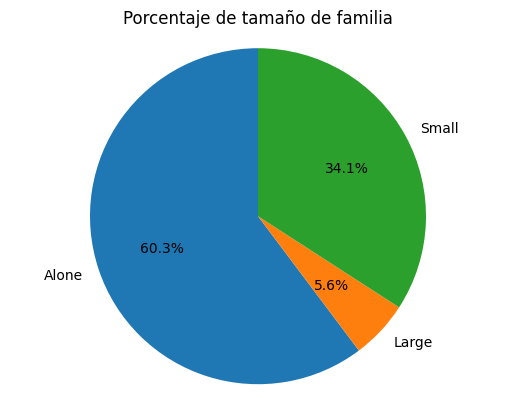

In [ ]:
family_size_counts = processed_df[['FamilySize_Alone', 'FamilySize_Large', 'FamilySize_Small']].sum()

labels = ['Alone', 'Large', 'Small']
sizes = [family_size_counts['FamilySize_Alone'], family_size_counts['FamilySize_Large'], family_size_counts['FamilySize_Small']]


fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')

plt.title('Porcentaje de tamaño de familia')
plt.show()

# Dataframe final

In [ ]:
processed_df = processing_pipeline.fit_transform(X_train)
processed_df

,WomanOrBoy,Fare,Age,Pclass,Marital_Status,Embarked_C,Embarked_Q,Embarked_S,FamilySize_Alone,FamilySize_Large,FamilySize_Small
PassengerId,,,,,,,,,,,
331.0,0.0,0.542291,0.75,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
733.0,0.0,0.422864,0.25,0.5,1.0,0.0,0.0,1.0,1.0,0.0,0.0
382.0,0.0,0.350727,0.50,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
704.0,0.0,0.349451,0.25,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
813.0,1.0,0.556696,0.00,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
106.0,1.0,0.345712,0.25,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
270.0,0.0,0.555325,0.50,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
860.0,0.0,0.435071,0.75,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


# Explorar errores y variables más importantes

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(processed_df, y_train)
log_reg_acc_scores = cross_val_score(log_reg, processed_df, y_train, cv=stratified_kfold)
log_reg_f1_scores = cross_val_score(log_reg, processed_df, y_train, cv=stratified_kfold, scoring="f1")

print("Accuracy score: ", log_reg_acc_scores.mean())
print("Standard deviation: ", log_reg_acc_scores.std())
print()
print("F1 score: ", log_reg_f1_scores.mean())
print("Standard deviation: ", log_reg_f1_scores.std())

Accuracy score:  0.828612232837585
Standard deviation:  0.026365514957829645

F1 score:  0.7672935451920615
Standard deviation:  0.03382272178759954


### Importancia de características

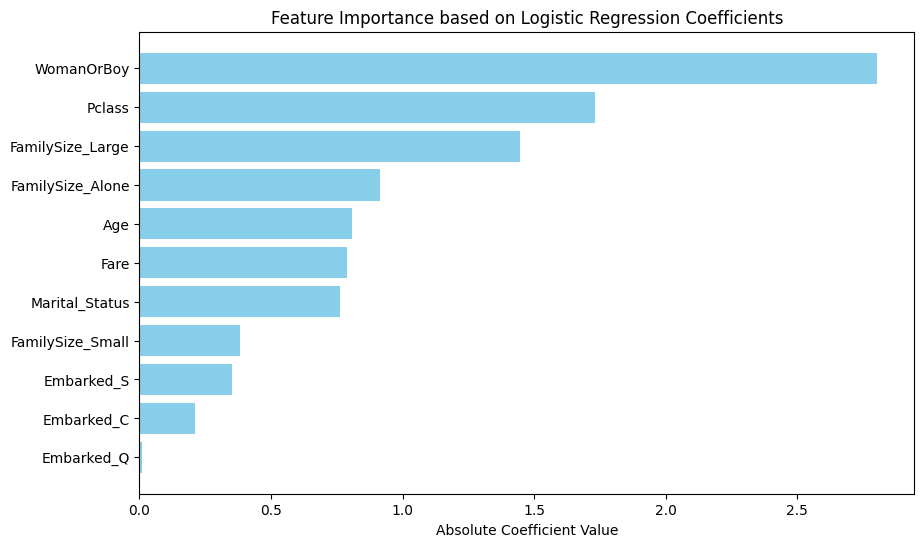

In [ ]:
coefficients = log_reg.coef_[0]

feature_importance_df = pd.DataFrame({
    'Feature': processed_df.columns,
    'Coefficient': coefficients
})

feature_importance_df['Absolute Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Graficar las importancias
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Absolute Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance based on Logistic Regression Coefficients')
plt.gca().invert_yaxis()
plt.show()

### Errores cometidos

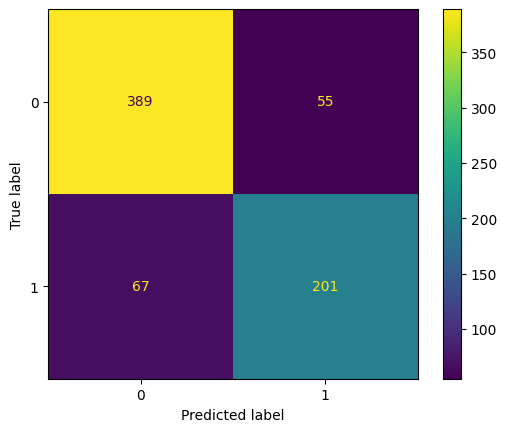

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86       444
           1       0.79      0.75      0.77       268

    accuracy                           0.83       712
   macro avg       0.82      0.81      0.82       712
weighted avg       0.83      0.83      0.83       712

Total de errores: 122
Instancias mal clasificadas:



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,y_pred
118,119,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,1
55,56,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S,0
81,82,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.5000,NaN,S,0
534,535,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S,1
762,763,3,"Barah, Mr. Hanna Assi",male,20.0,0,0,2663,7.2292,NaN,C,0
...,...,...,...,...,...,...,...,...,...,...,...,...
681,682,1,"Hassab, Mr. Hammad",male,27.0,0,0,PC 17572,76.7292,D49,C,0
510,511,3,"Daly, Mr. Eugene Patrick",male,29.0,0,0,382651,7.7500,NaN,Q,0
474,475,3,"Strandberg, Miss. Ida Sofia",female,22.0,0,0,7553,9.8375,NaN,S,1
21,22,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S,0


In [ ]:
y_pred = cross_val_predict(log_reg, processed_df, y_train, cv=stratified_kfold)

conf_matrix = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

print("Classification Report:\n", classification_report(y_train, y_pred))

# Instancias mal clasificadas
errores = (y_train != y_pred).values
errores_df = X_train.loc[errores].copy()
errores_df['y_pred'] = y_pred[errores]
print(f"Total de errores: {errores.sum()}")
print("Instancias mal clasificadas:\n")
errores_df

## Random Forest

In [ ]:
rnd_forest = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_forest.fit(processed_df, y_train)
rnd_forest_acc_scores = cross_val_score(rnd_forest, processed_df, y_train, cv=stratified_kfold)
rnd_forest_f1_scores = cross_val_score(rnd_forest, processed_df, y_train, cv=stratified_kfold, scoring="f1")

print("Accuracy score: ", rnd_forest_acc_scores.mean())
print("Standard deviation: ", rnd_forest_acc_scores.std())
print()
print("F1 score: ", rnd_forest_f1_scores.mean())
print("Standard deviation: ", rnd_forest_f1_scores.std())

Accuracy score:  0.8005614104205654
Standard deviation:  0.023694539042849162

F1 score:  0.7299319628291309
Standard deviation:  0.029982901495586443


### Importancia de características

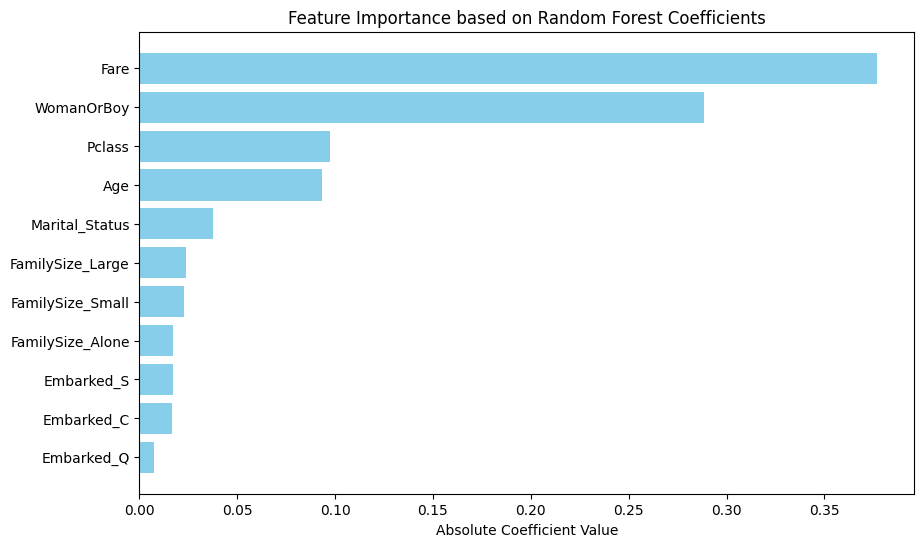

In [ ]:
coefficients = rnd_forest.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': processed_df.columns,
    'Coefficient': coefficients
})

feature_importance_df['Absolute Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Graficar las importancias
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Absolute Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance based on Random Forest Coefficients')
plt.gca().invert_yaxis()
plt.show()

# Guardar los resultados
featImp_rndForest_df = feature_importance_df.copy()

### Errores cometidos

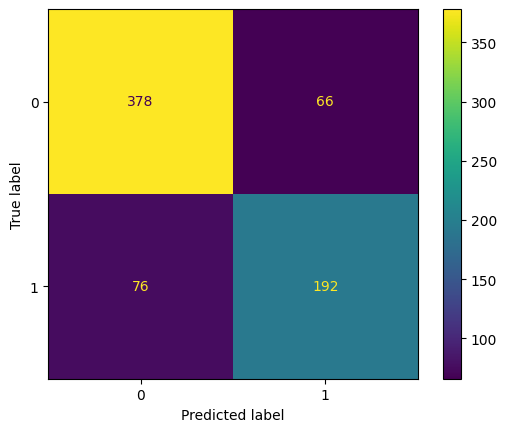

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84       444
           1       0.74      0.72      0.73       268

    accuracy                           0.80       712
   macro avg       0.79      0.78      0.79       712
weighted avg       0.80      0.80      0.80       712

Total de errores: 142
Instancias mal clasificadas:



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,y_pred
331,332,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S,1
704,705,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S,1
118,119,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,1
536,537,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S,1
55,56,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
510,511,3,"Daly, Mr. Eugene Patrick",male,29.0,0,0,382651,7.7500,NaN,Q,0
474,475,3,"Strandberg, Miss. Ida Sofia",female,22.0,0,0,7553,9.8375,NaN,S,1
21,22,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S,0
99,100,2,"Kantor, Mr. Sinai",male,34.0,1,0,244367,26.0000,NaN,S,1


In [ ]:
y_pred = cross_val_predict(rnd_forest, processed_df, y_train, cv=stratified_kfold)

conf_matrix = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

print("Classification Report:\n", classification_report(y_train, y_pred))

# Instancias mal clasificadas
errores = (y_train != y_pred).values
errores_df = X_train.loc[errores].copy()
errores_df['y_pred'] = y_pred[errores]
print(f"Total de errores: {errores.sum()}")
print("Instancias mal clasificadas:\n")
errores_df

## Gradient Boosting

In [ ]:
grad_bost = GradientBoostingClassifier(n_estimators=100, random_state=42)
grad_bost.fit(processed_df, y_train)
grad_bost_acc_scores = cross_val_score(grad_bost, processed_df, y_train, cv=stratified_kfold)
grad_bost_f1_scores = cross_val_score(grad_bost, processed_df, y_train, cv=stratified_kfold, scoring="f1")

print("Accuracy score: ", grad_bost_acc_scores.mean())
print("Standard deviation: ", grad_bost_acc_scores.std())
print()
print("F1 score: ", grad_bost_f1_scores.mean())
print("Standard deviation: ", grad_bost_f1_scores.std())

Accuracy score:  0.832867132867133
Standard deviation:  0.016239393417876034

F1 score:  0.7627337598088612
Standard deviation:  0.018036964531556014


In [ ]:
print(grad_bost.get_params())

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


### Importancia de características

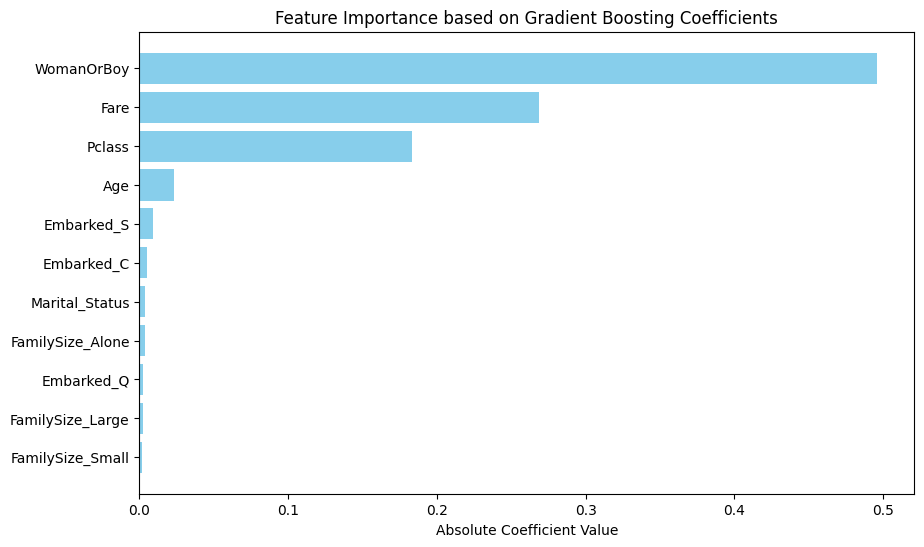

In [ ]:
importances = grad_bost.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': processed_df.columns, 'Coefficient': importances})

feature_importance_df['Absolute Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Graficar las importancias
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Absolute Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance based on Gradient Boosting Coefficients')
plt.gca().invert_yaxis()
plt.show()

# Guardar los resultados
featImp_gradBost_df = feature_importance_df.copy()

### Errores cometidos

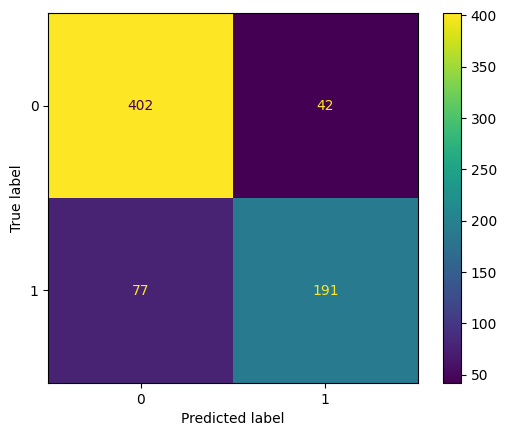

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87       444
           1       0.82      0.71      0.76       268

    accuracy                           0.83       712
   macro avg       0.83      0.81      0.82       712
weighted avg       0.83      0.83      0.83       712

Total de errores: 119
Instancias mal clasificadas:



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,y_pred
55,56,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S,0
81,82,3,"Sheerlinck, Mr. Jan Baptist",male,29.0000,0,0,345779,9.5000,NaN,S,0
762,763,3,"Barah, Mr. Hanna Assi",male,20.0000,0,0,2663,7.2292,NaN,C,0
199,200,2,"Yrois, Miss. Henriette ('Mrs Harbeck')",female,24.0000,0,0,248747,13.0000,NaN,S,1
305,306,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
510,511,3,"Daly, Mr. Eugene Patrick",male,29.0000,0,0,382651,7.7500,NaN,Q,0
21,22,2,"Beesley, Mr. Lawrence",male,34.0000,0,0,248698,13.0000,D56,S,0
330,331,3,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.2500,NaN,Q,0
106,107,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0000,0,0,343120,7.6500,NaN,S,0


In [ ]:
y_pred = cross_val_predict(grad_bost, processed_df, y_train, cv=stratified_kfold)

conf_matrix = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

print("Classification Report:\n", classification_report(y_train, y_pred))

# Instancias mal clasificadas
errores = (y_train != y_pred).values
errores_df = X_train.loc[errores].copy()
errores_df['y_pred'] = y_pred[errores]
print(f"Total de errores: {errores.sum()}")
print("Instancias mal clasificadas:\n")
errores_df

## SVM

In [ ]:
svm = SVC()
svm.fit(processed_df, y_train)
svm_acc_scores = cross_val_score(svm, processed_df, y_train, cv=stratified_kfold)
svm_f1_scores = cross_val_score(svm, processed_df, y_train, cv=stratified_kfold, scoring="f1")

print("Accuracy score: ", svm_acc_scores.mean())
print("Standard deviation: ", svm_acc_scores.std())
print()
print("F1 score: ", svm_f1_scores.mean())
print("Standard deviation: ", svm_f1_scores.std())

Accuracy score:  0.8286319314488327
Standard deviation:  0.028389902052175363

F1 score:  0.7615361854973506
Standard deviation:  0.040048118340336475


### Importancia de características

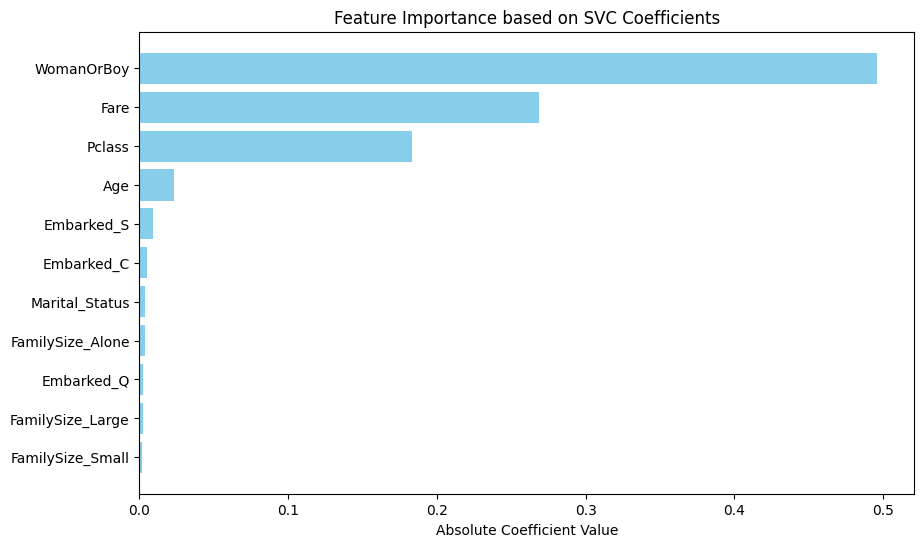

In [ ]:
result = permutation_importance(svm, processed_df, y_train, n_repeats=10, random_state=42)

feature_importance = pd.DataFrame({
    'Feature': processed_df.columns,
    'Coefficient': result.importances_mean
})

feature_importance_df['Absolute Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Graficar las importancias
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Absolute Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance based on SVC Coefficients')
plt.gca().invert_yaxis()
plt.show()

# Guardar los resultados
featImp_SVM_df = feature_importance_df.copy()

### Errores cometidos

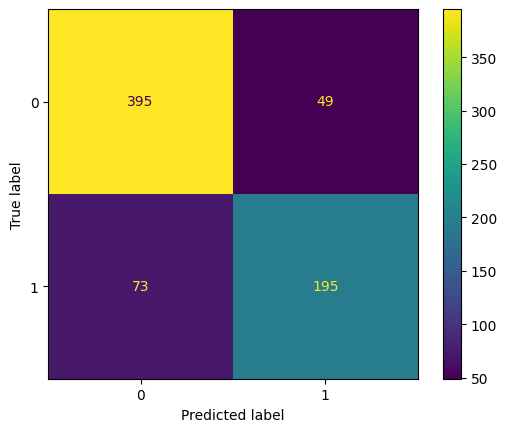

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87       444
           1       0.80      0.73      0.76       268

    accuracy                           0.83       712
   macro avg       0.82      0.81      0.81       712
weighted avg       0.83      0.83      0.83       712

Total de errores: 122
Instancias mal clasificadas:



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,y_pred
55,56,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S,0
81,82,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.5000,NaN,S,0
534,535,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S,1
762,763,3,"Barah, Mr. Hanna Assi",male,20.0,0,0,2663,7.2292,NaN,C,0
390,391,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
681,682,1,"Hassab, Mr. Hammad",male,27.0,0,0,PC 17572,76.7292,D49,C,0
510,511,3,"Daly, Mr. Eugene Patrick",male,29.0,0,0,382651,7.7500,NaN,Q,0
474,475,3,"Strandberg, Miss. Ida Sofia",female,22.0,0,0,7553,9.8375,NaN,S,1
21,22,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S,0


In [ ]:
y_pred = cross_val_predict(svm, processed_df, y_train, cv=stratified_kfold)

conf_matrix = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

print("Classification Report:\n", classification_report(y_train, y_pred))

# Instancias mal clasificadas
errores = (y_train != y_pred).values
errores_df = X_train.loc[errores].copy()
errores_df['y_pred'] = y_pred[errores]
print(f"Total de errores: {errores.sum()}")
print("Instancias mal clasificadas:\n")
errores_df

Modelos más complejos como **Gradient Boosting** y **SVM** lograron el mejor rendimiento. A pesar de tener una desviación estándar ligeramente mayor, lo que sugiere cierta variabilidad en el rendimiento, estos modelos tienen mayor flexibilidad para capturar patrones no lineales y complejos en los datos. Con ajustes adicionales y optimización de hiperparámetros, estos modelos podrían mejorar aún más su capacidad predictiva.


## Características más importantes (en general)

In [ ]:
featImp_gradBost_df = featImp_gradBost_df.rename(columns={'Coefficient': 'GradBoost_Coeff'})
featImp_rndForest_df = featImp_rndForest_df.rename(columns={'Coefficient': 'RndForest_Coeff'})
featImp_SVM_df = featImp_SVM_df.rename(columns={'Coefficient': 'SVM_Coeff'})

combined_df = featImp_gradBost_df.merge(featImp_rndForest_df, on='Feature').merge(featImp_SVM_df, on='Feature')
combined_df['Mean_Coefficient'] = combined_df[['GradBoost_Coeff', 'RndForest_Coeff', 'SVM_Coeff']].mean(axis=1)
combined_df = combined_df.sort_values(by='Mean_Coefficient', ascending=False)
combined_df[['Feature', 'Mean_Coefficient']]

,Feature,Mean_Coefficient
0,WomanOrBoy,0.427021
1,Fare,0.304693
2,Pclass,0.154460
3,Age,0.046499
6,Marital_Status,0.015205
4,Embarked_S,0.011907
9,FamilySize_Large,0.009585
10,FamilySize_Small,0.008972
5,Embarked_C,0.008911
7,FamilySize_Alone,0.008355


Estas variables pueden señalar **sesgos** inherentes a los datos históricos del Titanic. Algunos de los más relevantes son:

- Sesgos sociales: Las mujeres y los niños fueron priorizados para subir a los botes salvavidas, lo que se traduce en una mayor probabilidad de supervivencia en los datos.

- Sesgo de clase socioeconómica: Los pasajeros de clase alta, que pagaron más por sus boletos, tenían más probabilidades de acceder a recursos como los botes salvavidas, lo que aumenta su tasa de supervivencia.

- Sesgo basado en la edad: Los niños fueron priorizados en los procedimientos de evacuación, lo que favorece su supervivencia en los datos.

- Sesgo de ubicación: La ubicación física en el barco, generalmente asociada a la clase socioeconómica o el acceso a recursos, influye en la probabilidad de supervivencia.

- Sesgo geográfico o regional: El puerto de embarque tiene un impacto menor en la predicción, pero aún representa un sesgo leve relacionado con la procedencia de los pasajeros.

Aunque estos patrones reflejan la realidad histórica de los datos, no representan diferencias inherentes en la capacidad de supervivencia, sino las **condiciones sociales** y estructurales de la época.

Es fundamental tener en cuenta estos sesgos si los modelos se aplican a **predicciones futuras o en contextos diferentes**, donde las condiciones sociales o demográficas puedan ser distintas.

# Búsqueda del mejor modelo

In [ ]:
from sklearn import svm
from sklearn import tree
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import ensemble
from sklearn import discriminant_analysis
from sklearn import gaussian_process
from xgboost import XGBClassifier

In [ ]:
def create_pipeline(algo):
    return Pipeline([
        ('processing', processing_pipeline),
        ('evaluate', algo)
    ])

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
algorithms=[
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),

    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    # Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    # Nearest Neighbors
    neighbors.KNeighborsClassifier(),

    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),

    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    # XGBoost
    XGBClassifier()
]

In [ ]:
model_names = []
CV_Accuracy=[]
CV_Deviation=[]
for algo in algorithms:
    pipeline = create_pipeline(algo)
    scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_kfold)
    model_names.append(algo.__class__.__name__)
    CV_Accuracy.append(scores.mean())
    CV_Deviation.append(scores.std())

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: Fu

In [ ]:
model_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': CV_Accuracy,
    'Standard deviation': CV_Deviation})

In [ ]:
model_df.sort_values(by='Accuracy', ascending=False, inplace=True)
model_df

,Model,Accuracy,Standard deviation
0,AdaBoostClassifier,0.831439,0.027170
14,SVC,0.827233,0.029701
6,LogisticRegressionCV,0.823028,0.026024
5,GaussianProcessClassifier,0.823008,0.029366
3,GradientBoostingClassifier,0.821629,0.022962
19,LinearDiscriminantAnalysis,0.821609,0.029377
8,RidgeClassifierCV,0.821609,0.029377
15,NuSVC,0.820201,0.028718
16,LinearSVC,0.818792,0.029356
21,XGBClassifier,0.816054,0.021050


# Perfeccionar los mejores modelos

## Gradient Boosting Classifier

In [ ]:
# gbm = GradientBoostingClassifier()

# param_dist = {
#     'n_estimators': randint(low=50, high=500),
#     'learning_rate': uniform(0.01, 0.03),
#     'max_depth': randint(low=2, high=12),
#     'min_samples_split': randint(low=2, high=25),
# }

# # Configurar RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=gbm,
#                                    param_distributions=param_dist,
#                                    n_iter=300,
#                                    cv=stratified_kfold,
#                                    verbose=2,
#                                    random_state=42)

# # Ajustar el modelo
# random_search.fit(processed_df, y_train)

# # Mostrar los mejores parámetros
# print("Mejores hiperparámetros encontrados: ", random_search.best_params_)
# print("Mejor exactitud: ", random_search.best_score_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END learning_rate=0.021236203565420872, max_depth=9, min_samples_split=22, n_estimators=152; total time=   2.0s
[CV] END learning_rate=0.021236203565420872, max_depth=9, min_samples_split=22, n_estimators=152; total time=   3.5s
[CV] END learning_rate=0.021236203565420872, max_depth=9, min_samples_split=22, n_estimators=152; total time=   1.4s
[CV] END learning_rate=0.021236203565420872, max_depth=9, min_samples_split=22, n_estimators=152; total time=   0.8s
[CV] END learning_rate=0.021236203565420872, max_depth=9, min_samples_split=22, n_estimators=152; total time=   0.6s
[CV] END learning_rate=0.02337498258560773, max_depth=8, min_samples_split=12, n_estimators=137; total time=   0.6s
[CV] END learning_rate=0.02337498258560773, max_depth=8, min_samples_split=12, n_estimators=137; total time=   0.5s
[CV] END learning_rate=0.02337498258560773, max_depth=8, min_samples_split=12, n_estimators=137; total time=   0.6s
[CV

In [ ]:
# results_df = pd.DataFrame(random_search.cv_results_)
# results_df = results_df[['params', 'mean_test_score', 'std_test_score']]
# results_df = results_df.sort_values(by='mean_test_score', ascending=False)
# results_df.reset_index(drop=True, inplace=True)
# results_df.head(12)

,params,mean_test_score,std_test_score
0,"{'learning_rate': 0.02860928654060394, 'max_de...",0.841288,0.015179
1,"{'learning_rate': 0.036761396655313396, 'max_d...",0.837083,0.013573
2,"{'learning_rate': 0.025895200695433503, 'max_d...",0.837073,0.022822
3,"{'learning_rate': 0.020466047996289857, 'max_d...",0.837063,0.024538
4,"{'learning_rate': 0.039599187355035266, 'max_d...",0.837063,0.024538
5,"{'learning_rate': 0.02137685754891401, 'max_de...",0.837063,0.024538
6,"{'learning_rate': 0.022444585070129953, 'max_d...",0.837063,0.024538
7,"{'learning_rate': 0.029364168877215033, 'max_d...",0.837063,0.024538
8,"{'learning_rate': 0.03581213854935026, 'max_de...",0.837063,0.024538
9,"{'learning_rate': 0.011901249114183032, 'max_d...",0.837053,0.026136


Mejores hiperparámetros encontrados:  {'learning_rate': 0.02860928654060394, 'max_depth': 3, 'min_samples_split': 12, 'n_estimators': 484}
Mejor exactitud:  0.8412882891756132

## SVM

In [ ]:
# svm = SVC()

In [ ]:
# param_dist = {
#     'C': uniform(0.0001, 100),
#     'gamma': uniform(0.001, 0.1),
#     'kernel': ['rbf']
# }

# random_search = RandomizedSearchCV(estimator=svm,
#                                    param_distributions=param_dist,
#                                    n_iter=100,
#                                    cv=stratified_kfold,
#                                    verbose=2,
#                                    random_state=42)

# random_search.fit(processed_df, y_train)

# print("Mejores hiperparámetros encontrados: ", random_search.best_params_)
# print("Mejor exactitud: ", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=37.45411188473625, gamma=0.09607143064099162, kernel=rbf; total time=   0.0s
[CV] END C=37.45411188473625, gamma=0.09607143064099162, kernel=rbf; total time=   0.0s
[CV] END C=37.45411188473625, gamma=0.09607143064099162, kernel=rbf; total time=   0.0s
[CV] END C=37.45411188473625, gamma=0.09607143064099162, kernel=rbf; total time=   0.0s
[CV] END C=37.45411188473625, gamma=0.09607143064099162, kernel=rbf; total time=   0.0s
[CV] END C=73.19949418114051, gamma=0.06086584841970366, kernel=rbf; total time=   0.0s
[CV] END C=73.19949418114051, gamma=0.06086584841970366, kernel=rbf; total time=   0.0s
[CV] END C=73.19949418114051, gamma=0.06086584841970366, kernel=rbf; total time=   0.0s
[CV] END C=73.19949418114051, gamma=0.06086584841970366, kernel=rbf; total time=   0.0s
[CV] END C=73.19949418114051, gamma=0.06086584841970366, kernel=rbf; total time=   0.0s
[CV] END C=15.601964044243651, gamma=0.016599452033620267

In [ ]:
# results_df = pd.DataFrame(random_search.cv_results_)
# results_df = results_df[['params', 'mean_test_score', 'std_test_score']]
# results_df = results_df.sort_values(by='mean_test_score', ascending=False)
# results_df.reset_index(drop=True, inplace=True)
# results_df.head()

,params,mean_test_score,std_test_score
0,"{'C': 96.56330330745594, 'gamma': 0.0818397348...",0.831449,0.026311
1,"{'C': 80.74411551640625, 'gamma': 0.0906091299...",0.831449,0.026311
2,"{'C': 36.778413271925324, 'gamma': 0.064230583...",0.831439,0.026393
3,"{'C': 23.763854399239968, 'gamma': 0.073821634...",0.831439,0.026393
4,"{'C': 60.95653339798969, 'gamma': 0.0512679023...",0.831439,0.026393


## Ada Boost Classifier

In [ ]:
# ABC = ensemble.AdaBoostClassifier()

# param_dist = {
#     'n_estimators': randint(low=50, high=500),
#     'learning_rate': uniform(0.01, 0.03),
#     'algorithm': ['SAMME', 'SAMME.R']
# }

# random_seach = RandomizedSearchCV(estimator=ABC,
#                                    param_distributions=param_dist,
#                                    n_iter=100,
#                                    cv=stratified_kfold,
#                                    verbose=2,
#                                    random_state=42)

# random_search.fit(processed_df, y_train)

# print("Mejores hiperparámetros encontrados: ", random_search.best_params_)
# print("Mejor exactitud: ", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=37.45411188473625, gamma=0.09607143064099162, kernel=rbf; total time=   0.0s
[CV] END C=37.45411188473625, gamma=0.09607143064099162, kernel=rbf; total time=   0.0s
[CV] END C=37.45411188473625, gamma=0.09607143064099162, kernel=rbf; total time=   0.0s
[CV] END C=37.45411188473625, gamma=0.09607143064099162, kernel=rbf; total time=   0.0s
[CV] END C=37.45411188473625, gamma=0.09607143064099162, kernel=rbf; total time=   0.0s
[CV] END C=73.19949418114051, gamma=0.06086584841970366, kernel=rbf; total time=   0.0s
[CV] END C=73.19949418114051, gamma=0.06086584841970366, kernel=rbf; total time=   0.0s
[CV] END C=73.19949418114051, gamma=0.06086584841970366, kernel=rbf; total time=   0.0s
[CV] END C=73.19949418114051, gamma=0.06086584841970366, kernel=rbf; total time=   0.0s
[CV] END C=73.19949418114051, gamma=0.06086584841970366, kernel=rbf; total time=   0.0s
[CV] END C=15.601964044243651, gamma=0.016599452033620267

In [ ]:
# results_df = pd.DataFrame(random_search.cv_results_)
# results_df = results_df[['params', 'mean_test_score', 'std_test_score']]
# results_df = results_df.sort_values(by='mean_test_score', ascending=False)
# results_df.reset_index(drop=True, inplace=True)
# results_df.head()

,params,mean_test_score,std_test_score
0,"{'C': 96.56330330745594, 'gamma': 0.0818397348...",0.831449,0.026311
1,"{'C': 80.74411551640625, 'gamma': 0.0906091299...",0.831449,0.026311
2,"{'C': 36.778413271925324, 'gamma': 0.064230583...",0.831439,0.026393
3,"{'C': 23.763854399239968, 'gamma': 0.073821634...",0.831439,0.026393
4,"{'C': 60.95653339798969, 'gamma': 0.0512679023...",0.831439,0.026393


# Enviar resultados

In [ ]:
gbm = GradientBoostingClassifier(learning_rate=0.025895200695433503, max_depth=2, min_samples_split=15, n_estimators=369)

pipeline = create_pipeline(gbm)

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('processing',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('columntransformer-1',
                                                   ColumnTransformer(remainder='passthrough',
                                                                     transformers=[('title',
                                                                                    Pipeline(steps=[('nameimputer',
                                                                                                     NameImputer()),
                                                                                                    ('titleextractor',
                                                                                                     TitleExtractor())]),
                                                                                    ['Name']),
                                                                                   ('surname',
                                                                                    Pipeline(steps=[('nameimputer',
                                                                                                     NameImputer()),
                                                                                                    ('surnameextractor',
                                                                                                     SurnameExtractor(...
                                                                     verbose_feature_names_out=False)),
                                                  ('customfunctiontransformer-2',
                                                   CustomFunctionTransformer(func=<function to_dataframe_2 at 0x7a404647f760>))])),
                                 ('customfunctiontransformer',
                                  CustomFunctionTransformer(func=<function remove_columns at 0x7a4046432680>))])),
                ('evaluate',
                 GradientBoostingClassifier(learning_rate=0.025895200695433503,
                                            max_depth=2, min_samples_split=15,
                                            n_estimators=369))])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = pipeline.predict(X_val)
print("Exactitud: ",accuracy_score(y_val, y_pred))
print("F1 score: ",f1_score(y_val, y_pred))

Exactitud:  0.8212290502793296
F1 score:  0.7777777777777778


In [ ]:
submission = pd.DataFrame()
submission["PassengerId"] = test["PassengerId"]
submission

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [ ]:
predictions = pipeline.predict(test)
submission["Survived"] =  predictions
submission.to_csv("submission.csv", index=False)

In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>